In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import spearmanr,pearsonr, linregress
import pandas as pd
# import sys
# sys.path.append("../")  # should just add to 
from bloom_filters import * 
T = np.transpose

In [3]:
# Odors of Interest from novelty paper

## Present Hallem data set
# (ACP) acetophenone       -neutral [present] {-3, 10, 62}
# (BEN) benzaldehyde       -aversive [present] {5, 200, 57}
# (MBL) 3-methyl-1-butanol -neutral [present] {30, 157, 97} **here called 3-methylbutanol
# (IPA) isopentyl acetate  -attractive [present] {65, -33, 139}
# (HXA) hexyl acetate      -attractive [present] {29, -19, 44}

## Absent Hallem data set
# (MCH) 4-methylcyclohexanol -aversive [absent]
# (OCT) 3-octanol            - aversive [absent]

# parameters
m = 350
k = 17
SB_str = 'SB4'
include_oil = False  # inferred Suppression index
include_BEN2 = True  # panel 2 fig. 2

In [4]:
# Utility Functions
def hamming_distance(x1,x2):
    assert(len(x1)==len(x2))
    try:
        return sum(x1^x2) # ^ is xor
    except:
        return sum((x1>0)^(x2>0)) # ^ is xor
def one_tail_pearson(x,y):
    r,p = pearsonr(x,y)
    return (r,p/2)
def discrete_matshow(data):
    #get discrete colormap
    cmap = plt.get_cmap('Pastel1', (np.max(data)-np.min(data)+1))
    # set limits .5 outside true range
    mat = plt.imshow(data,cmap=cmap,vmin = np.min(data)-.5, vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat, ticks=np.arange(np.min(data),np.max(data)+1,2))
    return cax
def std_err(X):
    # assumes along columns
    return np.std(X,axis=0)/np.sqrt(np.shape(X)[0])

# Load DoOR dataset

In [5]:
dat = pd.read_csv("DRM.csv")
#dat = dat.drop(columns='Unnamed: 0') # doesn't work w/ old pandas
dat = dat.drop(labels='Unnamed: 0',axis=1)
dat_mat = np.array(dat) # 693 odors x 78 responses
tot_n_odor, tot_n_ord = np.shape(dat_mat)

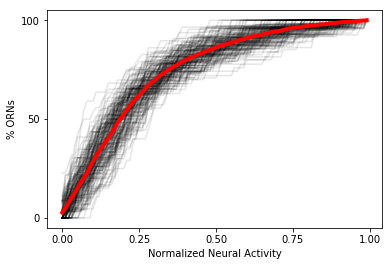

In [6]:
subtract_mean = True
avg_bins = []
for i in range(tot_n_odor):
    try:
        this_dat = dat_mat[i]
        this_dat = this_dat[~np.isnan(this_dat)]
        if len(this_dat)<20:
            continue
        if subtract_mean:
            this_dat = this_dat * (.3/np.mean(this_dat))
        n_bin, bins = np.histogram(this_dat,np.arange(0,1.01,.01))

        cdf = np.cumsum(n_bin)/sum(n_bin)
        #t = np.arange(0,1,1/len(this_dat))
        t = bins[:-1]
        plt.plot(t, cdf*100,'k',alpha=.1)
        avg_bins.append(cdf)
    except:
        pass
else:
    rcParams.update({'font.size': 22})
    avg_trace = np.mean(np.stack(avg_bins),axis=0)
    plt.plot(t, avg_trace*100,'r',linewidth=4)
    rcParams.update({'font.size': 22})
    plt.xlabel('Normalized Neural Activity')
    plt.ylabel('% ORNs')
    plt.show()

In [7]:
dat_s = pd.read_csv("novelty_odors.csv") # just odors derived included in HattoriEtal2017
dat_s = dat_s.drop(labels='Unnamed: 0',axis=1)
if ~include_oil:
    dat_s = dat_s.drop(labels='OIL',axis=1)
n_odor_novel = np.shape(dat_s)[1]


In [8]:
X = np.array(dat_s) # 78 ORNs x 7/8 Odors
complete_odors = np.sum(~np.isnan(T(X)),axis=0)==n_odor_novel # 78 x 7/8 odors (many NaNs)
X_comp = X[complete_odors] # 21 x 7/8 Odors (all complete)

# Project to KC Space

In [9]:
# Project DoOR to KC space
# X_comp # 21 x 8
n_orn, n_odor = np.shape(X_comp)
Xu = T(X_comp) # 8 x 21

Xz = T(X_comp *100/np.mean(X_comp,axis=0)) # set mean rate to 100 for each odor
outHash,datHash,datIn = generate_hash_space_wDat(Xz,m=m,k=k,sparseBinary=SB_str)
this_h = np.zeros((n_odor,n_odor))
for i in range(n_odor):
    for j in range(n_odor):
        this_h[i,j] = hamming_distance(outHash[i],outHash[j])


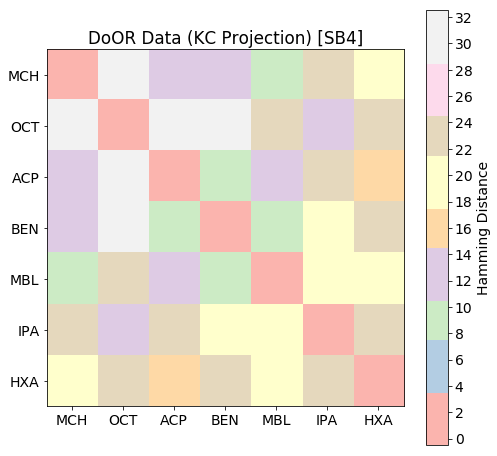

In [10]:
rcParams.update({'font.size': 14})
plt.figure(figsize=(8,8))
cbar = discrete_matshow(this_h)
cbar.set_label('Hamming Distance')
plt.xticks(range(n_odor_novel),dat_s.columns)
plt.yticks(range(n_odor_novel),dat_s.columns)
plt.title('DoOR Data (KC Projection) [' + SB_str + ']')
plt.show()

# Perform KC HASH (SB and DG)

In [11]:
n_reps = 30
MCH_hash_t = np.zeros((n_reps,n_odor_novel))
MCH_hashSB_t=np.zeros((n_reps,n_odor_novel))
for ii in range(n_reps): 
    outHash,_,_ = generate_hash_space_wDat(Xz,m=m,k=k,sparseBinary=None) # DENSE GAUSSIAN
    outHashSB,_,_ = generate_hash_space_wDat(Xz,m=m,k=k,sparseBinary=SB_str) # SPARSE BINARY
    this_h = np.zeros((n_odor,n_odor))
    this_hSB = np.zeros((n_odor,n_odor))
    for i in range(n_odor):
        for j in range(n_odor):
            this_h[i,j] = hamming_distance(outHash[i],outHash[j])
            this_hSB[i,j] = hamming_distance(outHashSB[i],outHashSB[j])
    MCH_hash_t[ii,:] = this_h[0,:] # distance from MCH
    MCH_hashSB_t[ii,:] = this_hSB[0,:]

# Distances in ORN space
Xd = Xz - Xz[0] # subtract MCH from all
Xd_euc_t = np.sum(Xd**2,axis=1)**.5 # _t temporary, needs to be cleaned
Xd_cos_t = np.dot(Xz,Xz[0])/(np.sum(Xz[0]**2)**.5*np.sum(Xz**2,axis=1)**.5) # questionable

In [12]:
# Supression data: (manually gathered from HattoriEtal2017 Fig. 2)
sup_dat = {'OCT':1.0,'ACP':.5,'BEN':1.0,'BEN2':0.7,'MBL':.65,'IPA':.85
           ,'HXA':.95,'OIL':.95,'MCH':.1} 

o_list = list(dat_s.columns)
if include_BEN2:
    # append second MCH data to distance metrics
    ind_BEN = [ii == 'BEN' for ii in o_list]
    Xd_euc = np.append(Xd_euc_t,Xd_euc_t[ind_BEN])
    Xd_cos = np.append(Xd_cos_t,Xd_cos_t[ind_BEN])
    MCH_hash = np.concatenate([MCH_hash_t,MCH_hash_t[:,ind_BEN]],axis=1)
    MCH_hashSB = np.concatenate([MCH_hashSB_t,MCH_hashSB_t[:,ind_BEN]],axis=1)
    
    o_list.append('BEN2')
else:
    Xd_euc = Xd_euc_t
    Xd_cos = Xd_cos_t
    MCH_hash = MCH_hash_t
    MCH_hashSB = MCH_hashSB_t
# Note: OIL already removed

i = 0
xx = np.zeros(len(o_list)) # put SI data in odor order
for od in o_list: 
    #print (od)
    xx[i] = sup_dat[od]
    i+=1

# Plot Supression VS. ORN Distance

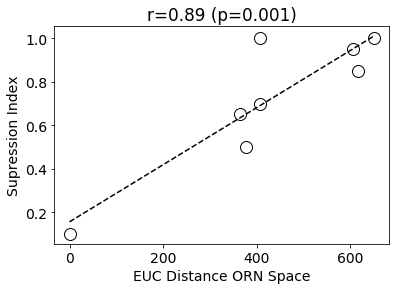

In [13]:
dist_view = 0
dist_view_str = ['EUC Distance','1-COS Similarity']
if dist_view == 0:
    x_use = Xd_euc
    xxx = np.array([0,300,650])
elif dist_view == 1:
    x_use = 1-Xd_cos
    xxx = np.array([0,.2,.45])
plt.plot(x_use[:],xx[:],'ko',ms=12,markerfacecolor='none')
plt.title('r=%.2f (p=%.3f)' %one_tail_pearson(x_use,xx))

# regression line
slope, intercept, _, pp, _ = linregress(x_use,xx)
plt.plot(xxx,xxx*slope+intercept,'k--')

plt.xlabel(dist_view_str[dist_view] + ' ORN Space')
plt.ylabel('Supression Index')
plt.show()

# Plot Supression VS. KC Distance

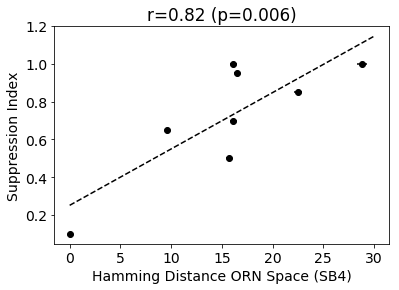

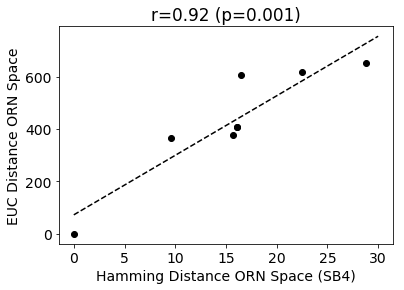

In [14]:
# plot SB hash vs. EUC distance ORN (curiosity)
# plot SB hash vs. SI (what a'3 MBON sees)
x_use_proj = np.mean(MCH_hashSB,axis=0)

plt.errorbar(x_use_proj,xx,xerr=std_err(MCH_hashSB),fmt='ko')
plt.ylabel('Suppression Index')
plt.xlabel('Hamming Distance ORN Space (' + SB_str + ')')
plt.title('r=%.2f (p=%.3f)' %one_tail_pearson(x_use_proj,xx))

# regression line
xxx = np.array([0, 15, 30])
slope, intercept, _, pp, _ = linregress(x_use_proj,xx)
plt.plot(xxx,xxx*slope+intercept,'k--')
plt.show()

plt.plot(x_use_proj,x_use,'ko')
plt.ylabel(dist_view_str[dist_view] + ' ORN Space')
plt.xlabel('Hamming Distance ORN Space (' + SB_str + ')')
plt.title('r=%.2f (p=%.3f)' %one_tail_pearson(x_use_proj,x_use))

# regression line
xxx = np.array([0, 15, 30])
slope, intercept, _, pp, _ = linregress(x_use_proj,x_use)
plt.plot(xxx,xxx*slope+intercept,'k--')
plt.show()

# Now Try to recreate fig2 using fly supression model

In [15]:
# generate S and q
# determine converging weights
# probably just use present odor function to get all outputs

# just present MCH 30 x
# np.shape(outHashSB) # odor x m
converge_weights = 0.38
wts = np.ones(m)*converge_weights
resp_1 = list()
for i in range(30):
    resp_t, wts = present_odor(outHashSB[0],wts)
    resp_1.append(resp_t)
#     print(i%n_odor_novel)
# just presnt all odors in loop to get converging weight values
resp_2 = list()
for i in range(100):
    resp_t, wts = present_odor(outHashSB[i%n_odor_novel],wts)
    resp_2.append(resp_t)

In [16]:
# present other odor x10 followed by MCH
rr = 0 # recovery rate 
odor_1 = 2
odor_2 = 0
n_odor_1 = 10
n_odor_2 = 3
fmt_type = 'o-'
color_wheel = ['g','b','y','r','k','m','c'] # try to match fig2
for odor_1 in range(8): # 8
    if odor_1 == 7:
        odor_1 = 0
        odor_2 = 3
    converge_weights = 1.0# 0.38
    wts = np.ones(m)*converge_weights
    resp_1 = list()
    for i in range(n_odor_1):
        resp_t, wts = present_odor(outHashSB[odor_1],wts,rr)
        resp_1.append(resp_t)
    for i in range(n_odor_2):
        resp_t, wts = present_odor(outHashSB[odor_2],wts,rr)
        resp_1.append(resp_t)
    fmt_1 = color_wheel[odor_1] + fmt_type 
    fmt_2 = color_wheel[odor_2] + fmt_type 

    plt.plot(np.arange(1,n_odor_1+1),resp_1[:n_odor_1],fmt_1,label = dat_s.columns[odor_1] )
    plt.plot(np.arange(n_odor_1+1,n_odor_1+1+n_odor_2),resp_1[n_odor_1:],fmt_2,label = dat_s.columns[odor_2])
    # grey line
    gl_ind = np.array([n_odor_1, n_odor_1+1])
    plt.plot(gl_ind,T(resp_1)[gl_ind-1],'k--')
    plt.legend()
    plt.ylabel('$\Delta$ F/F')
    #plt.show()
    plt_nam = 'figs/' + dat_s.columns[odor_1] + '_' + dat_s.columns[odor_2] + '.pdf'
    plt.savefig(plt_nam,bbox_inches='tight')
    plt.close()

In [ ]:
# Not perfect... may want to add sigmoid transform or something so weights dont need to sum to k
# to have response of 1